In [1]:
import numpy as np
import pandas as pd
import copy
import seaborn as sns
import matplotlib.pyplot as plt
import pydotplus as pdp
import pickle
%matplotlib inline

In [2]:
##コメントカキコミ版
## 2021.10.7: created based on List_Enumeration.ipynb
    # インスタンス変数の説明
    # - model = [rule1, ..., ruleL] : ルールのリスト．
    #   ここに，末尾のルールはデフォールトルール ruleL = (True, label)
    # - ifrule : 対(cond, label)．単一のif-then規則．(term => label)を表す
    # - term = {'feature':Feats, 'value':Vals} : 論理積(term)の条件条件
    #  　改訂案：Feats == Vals == []のとき，のとき，term == Trueとみなすとよい．
    # - Feats = [Feat1, ..., FeatK] : K個の属性（int）からなるリスト
    # - Vals = [Val1, ..., ValK] in {0,1}^K : K個のブール値(0,1)からなるリスト
    # - (Feats, Vals) : ブール等式条件 "Feats == Vals" を表す
class RuleList(object):
    def __init__(self, feature_name):
        self.model         = []
        self.feature_name  = feature_name
        self.default_label = None  #computed by split()

    # ifrule := (rule, label)
    def append_ifrule(self, ifrule):
        return self.model.append(ifrule)
    
    def append_default_label(self, lab):
        self.default_label = lab
    
    # ルールの追加
    # 入力  
    # - x    : データ（numpy ndarray）     
    # - y    : ラベル（numpy ndarray）
    # - rule : ルール　（dict, 例 : {'feature':[1, 2], 'value':[0, 1]}(means X1=0 & X2=1)）
    # 入力されたルールをモデルに追加する関数
    def add_rule(self, X, y, rule):
        S = np.arange(len(X))
        #print(S)
        
        self.model.append([rule, None])
        #print(self.model)

        for i in range(len(self.model)):
            S_child = self.split(S, X, self.model[i][0])
            if (i+1)!=len(self.model): 
                S = np.setdiff1d(S, S_child)

        if len(S_child) != 0:
            label = self.labeling(S_child, y)
            self.model[-1] = [rule, label]
        else: del self.model[-1]
    
    # 予測
    def predict(self, X):
        pred  = []
        for row in X:
            pred_i = self.flow(row)
            pred.append(pred_i)

        return np.array(pred)

    def __str__(self):
        text = ""
        for i in range(len(self.model)):
            rule = self.model[i][0]
            feature = rule["feature"]
            value = rule["value"]

            text += "if "
            for j in range(len(feature)):
                text += str(feature[j]) + " == " + str(value[j])
                if j+1 != len(feature): text += " & "
            
            text += ", then " + str(self.model[i][1]) + "\n"
        
        text += "else predict " + str(self.default_label)

        return text

    # 入力された規則に従うデータのインデックスを返す関数
    def split(self, S, X, rule):
        f_name = rule["feature"]
        feature = []
        for j in f_name:
            feature.append(self.feature_name.index(j))


        value = rule["value"]

        if feature == False: return S

        for i in range(len(feature)):
            x_value = X[S][:, feature[i]]
            index = np.where(x_value == value[i])
            S = S[index]

        return S

    # 入力されたインデックスからラベルを返す関数
    def labeling(self, S, y):
        return round( sum(y[S]) / len(y[S]) )

    # １行のデータをモデルに入力し、対応するラベルを返す関数
    def flow(self, x):
        for i in range(len(self.model)):
            cond = self.model[i][0]
            f_name = cond["feature"]
            feat = []
            for j in f_name:
                feat.append(self.feature_name.index(j))
            val = cond["value"]
            #print(rules)


            if all(x[feat]==val): return self.model[i][1]

        return self.default_label

    # 要検討
    # deep_copyをする関数を自分で実装したい
    # 一次元のリストに関しては、スライスを用いることでコピー可能
    # 2次元のリストに関しては、スライスでは不可能
    # 暫定的（10/9）deepcopy関数を使用
    def deep_copy(self):
        model_copy = copy.deepcopy(self.model)
        return model_copy

    def length(self):
        return len(self.model)

    def supp(self):
        f = []
        for i in range(len(self.model)):
            cond = self.model[i][0]
            f.append(cond)

        return f

    def label(self):
        l = []
        for i in range(len(self.model)):
            c_label = self.model[i][1]
            l.append(c_label)
        l.append(self.default_label)

        return l

In [3]:
train = pd.read_csv("../data/compas_train_race_preprocessed.csv", index_col=0)
train.head()

,race,recidivate-within-two-years,sex:Male,sex:Female,age:18-20,age:21-22,age:23-25,age:26-45,age:>45,juvenile-felonies:=0,...,juvenile-misdemeanors:=0,juvenile-misdemeanors:>0,juvenile-crimes:=0,juvenile-crimes:>0,priors:=0,priors:=1,priors:2-3,priors:>3,current-charge-degree:Felony,current-charge-degree:Misdemeanor
0,1,0,0,1,1,0,0,0,0,1,...,1,0,1,0,1,0,0,0,1,0
1,1,0,1,0,0,0,0,1,0,1,...,1,0,1,0,0,0,1,0,1,0
2,0,1,1,0,0,0,0,1,0,1,...,1,0,1,0,1,0,0,0,0,1
3,1,1,1,0,0,0,1,0,0,1,...,1,0,1,0,0,0,0,1,1,0
4,1,0,1,0,0,0,0,1,0,1,...,1,0,1,0,0,0,0,1,1,0


In [4]:
test = pd.read_csv("../data/compas_test_race_preprocessed.csv", index_col=0)
test.head()

,race,recidivate-within-two-years,sex:Male,sex:Female,age:18-20,age:21-22,age:23-25,age:26-45,age:>45,juvenile-felonies:=0,...,juvenile-misdemeanors:=0,juvenile-misdemeanors:>0,juvenile-crimes:=0,juvenile-crimes:>0,priors:=0,priors:=1,priors:2-3,priors:>3,current-charge-degree:Felony,current-charge-degree:Misdemeanor
0,1,0,1,0,0,0,0,1,0,1,...,1,0,1,0,0,0,0,1,1,0
1,0,1,1,0,0,0,0,1,0,1,...,1,0,1,0,0,0,0,1,0,1
2,1,1,1,0,0,0,0,1,0,1,...,1,0,1,0,0,0,0,1,1,0
3,0,1,1,0,0,0,1,0,0,1,...,1,0,1,0,0,0,1,0,1,0
4,1,0,1,0,0,0,0,1,0,1,...,1,0,1,0,1,0,0,0,0,1


In [5]:
corels = pd.read_pickle("corels_with_race.pkl")
print(type(corels))
print(corels[:10])

<class 'list'>
[(<__main__.RuleList object at 0x7f94f85efa58>, 2906), (<__main__.RuleList object at 0x7f94a2078898>, 3583), (<__main__.RuleList object at 0x7f94a20786d8>, 2906), (<__main__.RuleList object at 0x7f94a2078908>, 3689), (<__main__.RuleList object at 0x7f94a2078b38>, 2906), (<__main__.RuleList object at 0x7f94a2078ba8>, 3702), (<__main__.RuleList object at 0x7f94a2078a58>, 2893), (<__main__.RuleList object at 0x7f94a2089080>, 3689), (<__main__.RuleList object at 0x7f94a2089198>, 2906), (<__main__.RuleList object at 0x7f94a20892b0>, 3775)]


In [55]:
sort_corels = sorted(corels, key=lambda x: x[1])
sort_corels[:10]

[(<__main__.RuleList at 0x7f94d8840780>, 2258),
 (<__main__.RuleList at 0x7f94a21b18d0>, 2259),
 (<__main__.RuleList at 0x7f94a21c6a90>, 2264),
 (<__main__.RuleList at 0x7f94a21d2fd0>, 2268),
 (<__main__.RuleList at 0x7f94c89940f0>, 2269),
 (<__main__.RuleList at 0x7f94d876c9b0>, 2269),
 (<__main__.RuleList at 0x7f94d87a3400>, 2269),
 (<__main__.RuleList at 0x7f94d87a3940>, 2269),
 (<__main__.RuleList at 0x7f94d87a3e80>, 2269),
 (<__main__.RuleList at 0x7f94d8830cc0>, 2272)]

In [7]:
y_train = train["recidivate-within-two-years"].values
df = train.drop("recidivate-within-two-years", axis=1)
X_train = df.values

y_test = train["recidivate-within-two-years"].values
df = test.drop("recidivate-within-two-years", axis=1)
X_test = df.values

In [35]:
lawler = pd.read_pickle("lawler.pkl")
print(type(lawler))
print(lawler[:10])

<class 'list'>
[[<__main__.RuleList object at 0x7f94d89248d0>, 2258], [<__main__.RuleList object at 0x7f94d89b2048>, 2259], [<__main__.RuleList object at 0x7f94d8970198>, 2264], [<__main__.RuleList object at 0x7f94d89b8898>, 2268], [<__main__.RuleList object at 0x7f94d89b8a20>, 2269], [<__main__.RuleList object at 0x7f94d89b8160>, 2269], [<__main__.RuleList object at 0x7f94d89b8d30>, 2269], [<__main__.RuleList object at 0x7f94d89b82b0>, 2269], [<__main__.RuleList object at 0x7f94d89b8b70>, 2269], [<__main__.RuleList object at 0x7f94d89c0240>, 2272]]


## Compare existing method and proposed method

In [61]:
lawler_scores = []
reccorels_scores = []

err_num = len(X_train)
rho = 0.0
for i in range(len(lawler)):
    model1 = lawler[i][0]
    model2 = sort_corels[i][0]
    
    err = lawler[i][1] / err_num
    sc = err + rho * model1.length()
    lawler_scores.append(sc)
    
    err = sort_corels[i][1] / err_num
    sc = err + rho * model2.length()
    reccorels_scores.append(sc)

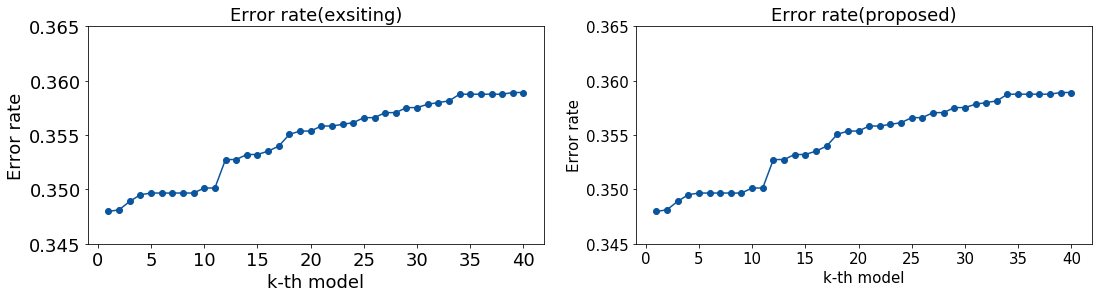

In [70]:
index = np.arange(1, len(lawler_scores)+1)

plt.rcParams["figure.figsize"] = (18, 4)
plt.rcParams["font.size"] = 18

fig = plt.figure()

ax = fig.add_subplot(1, 2, 1)
plt.plot(index, lawler_scores, marker="o")
plt.ylim(0.345, 0.365)
plt.rcParams["font.size"] = 15
plt.title("Error rate(exsiting)")
plt.xlabel("k-th model")
plt.ylabel("Error rate")

ax = fig.add_subplot(1, 2, 2)
plt.plot(index, reccorels_scores, marker="o")
plt.ylim(0.345, 0.365)
plt.rcParams["font.size"] = 15
plt.title("Error rate(proposed)")
plt.xlabel("k-th model")
plt.ylabel("Error rate")

plt.show()

In [71]:
lawler_scores = []
reccorels_scores = []

err_num = len(X_train)
rho = 0.015
for i in range(len(lawler)):
    model1 = lawler[i][0]
    model2 = sort_corels[i][0]
    
    err = lawler[i][1] / err_num
    sc = err + rho * model1.length()
    lawler_scores.append(sc)
    
    err = sort_corels[i][1] / err_num
    sc = err + rho * model2.length()
    reccorels_scores.append(sc)

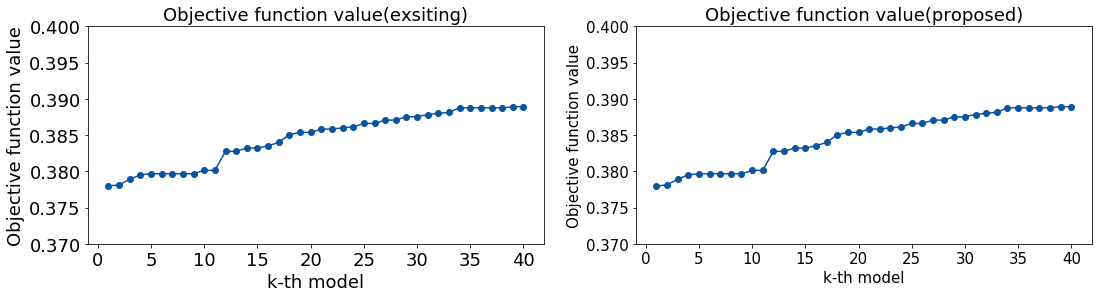

In [72]:
index = np.arange(1, len(lawler_scores)+1)

plt.rcParams["figure.figsize"] = (18, 4)
plt.rcParams["font.size"] = 18

fig = plt.figure()

ax = fig.add_subplot(1, 2, 1)
plt.plot(index, lawler_scores, marker="o")
plt.ylim(0.37, 0.4)
plt.rcParams["font.size"] = 15
plt.title("Objective function value(exsiting)")
plt.xlabel("k-th model")
plt.ylabel("Objective function value")

ax = fig.add_subplot(1, 2, 2)
plt.plot(index, reccorels_scores, marker="o")
plt.ylim(0.37, 0.4)
plt.rcParams["font.size"] = 15
plt.title("Objective function value(proposed)")
plt.xlabel("k-th model")
plt.ylabel("Objective function value")

plt.show()

## Calculate Fairness(DP and EQ)

In [10]:
def calc_dp(X, model, sensitive_feature):
    pred = model.predict(X)
    dp_1 = 0
    dp_0 = 0
    for i in range(len(pred)):
        if pred[i] == 1:
            if sensitive_feature[i] == 1: dp_1 += 1
            else: dp_0 += 1
    return abs(dp_1 - dp_0)/len(X)

def calc_eq(X, y, model, sensitive_feature):
    pred = model.predict(X)
    dp_1 = 0
    dp_0 = 0
    for i in range(len(pred)):
        if (pred[i] == 1) and (y[i]==1):
            if sensitive_feature[i] == 1: dp_1 += 1
            else: dp_0 += 1
    return abs(dp_1 - dp_0)/len(X)

In [11]:
sen_feat_train = train.race.values
sen_feat_train

array([1, 1, 0, ..., 0, 0, 1])

In [13]:
dp_train_list = []
eq_train_list = []

rashomon = best_score + 0.15 * err_num
model_list = [ row[0] for row in sort_corels if row[1] <= rashomon]
for i in model_list:
    dp = calc_dp(X_train, i, sen_feat_train)
    eq = calc_eq(X_train, y_train, i, sen_feat_train)
    dp_train_list.append(dp)
    eq_train_list.append(eq)
    
#print(dp_train_list)
#print()
#print(eq_train_list)

In [14]:
eps_list = []
num_model = []

dp_train_eps_list = []
eq_train_eps_list = []

for i in range(0, 16, 1):
    if i%5 == 0: print(i)
    eps = i / 100
    rashomon = best_score + eps * err_num
    model_list = [ row[0] for row in sort_corels if row[1] <= rashomon]
    eps_list.append(eps)
    num_model.append(len(model_list))
    
    dp_train_eps_list.append(dp_train_list[:len(model_list)])
    eq_train_eps_list.append(eq_train_list[:len(model_list)])
    
print(dp_train_eps_list[:1])
print(eq_train_eps_list[:1])

0
5
10
15
[[0.10695022345507782]]
[[0.08075204191709046]]


In [15]:
dp_test_list = []
eq_test_list = []
sen_feat_test = test.race.values

rashomon = best_score + 0.15 * err_num
model_list = [ row[0] for row in sort_corels if row[1] <= rashomon]
for i in model_list:
    dp = calc_dp(X_test, i, sen_feat_test)
    eq = calc_eq(X_test, y_test, i, sen_feat_test)
    dp_test_list.append(dp)
    eq_test_list.append(eq)
    
#print(dp_test_list)
#print()
#print(eq_test_list)

In [17]:
eps_list = []
num_model = []

dp_test_eps_list = []
eq_test_eps_list = []

for i in range(0, 16, 1):
    if i%5 == 0: print(i)
    eps = i / 100
    rashomon = best_score + eps * err_num
    model_list = [ row[0] for row in sort_corels if row[1] <= rashomon]
    eps_list.append(eps)
    num_model.append(len(model_list))
    
    dp_test_eps_list.append(dp_test_list[:len(model_list)])
    eq_test_eps_list.append(eq_test_list[:len(model_list)])
    
print(dp_test_eps_list[:1])
print(eq_test_eps_list[:1])

0
5
10
15
[[0.10957004160887657]]
[[0.02912621359223301]]


In [18]:
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 12

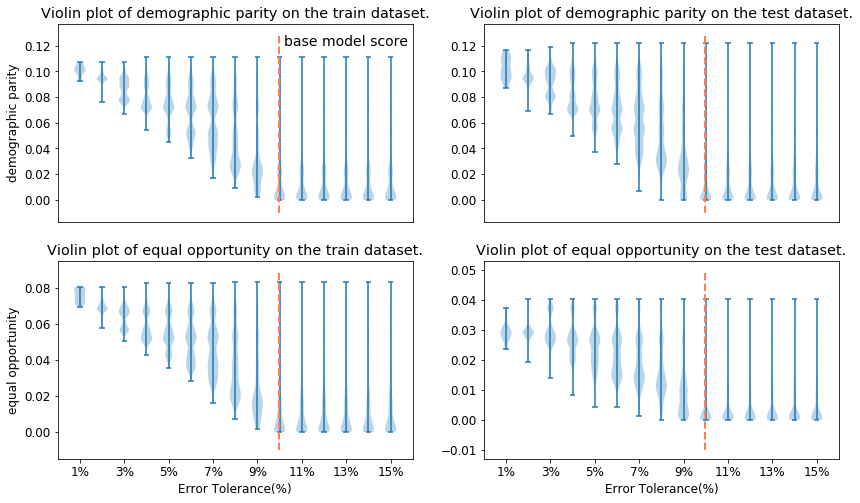

In [20]:
base_score = corels[0][1]
base_tolerance = (base_score - sort_corels[0][1]) / len(X_train) * 100

fig = plt.figure()

#sns.set_palette('gray')

ax = fig.add_subplot(2, 2, 1)
ax.violinplot(dp_train_eps_list[1:])
plt.title("Violin plot of demographic parity on the train dataset.")
#plt.xlabel("Error Tolerance(%)")
plt.ylabel("demographic parity")
#plt.ylim(-0,1, 0.13)
#plt.hlines(dp_train_eps_list[0], -1, 16, color="black", linestyle='dashed')
#plt.yticks([-0.02, 0.00, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14])
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15], ["1%", "3%", "5%", "7%", "9%", "11%", "13%", "15%"])
ax.axes.xaxis.set_visible(False)
plt.vlines(base_tolerance, -0.01, 0.13, color="coral", linestyle='dashed', linewidth=2)
ax.text(10.2, 0.12, "base model score", size=14, color='black')
plt.xlim(0, 16)
#plt.legend(loc="lower left")


ax = fig.add_subplot(2, 2, 2)
ax.violinplot(dp_test_eps_list[1:])
plt.title("Violin plot of demographic parity on the test dataset.")
#plt.xlabel("Error Tolerance(%)")
#plt.ylabel("demographic parity")
#plt.hlines(dp_test_eps_list[0], -1, 16, color="orange")
#plt.yticks([-0.02, 0.00, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14])
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15], ["1%", "3%", "5%", "7%", "9%", "11%", "13%", "15%"])
ax.axes.xaxis.set_visible(False)
#ax.axes.yaxis.set_visible(False)
plt.vlines(base_tolerance, -0.01, 0.13, color="coral", linestyle='dashed', linewidth=2)
#ax.text(10.2, 0.12, "base model score", size=14, color='black')
plt.xlim(0, 16)

ax = fig.add_subplot(2, 2, 3)
ax.violinplot(eq_train_eps_list[1:])
plt.title("Violin plot of equal opportunity on the train dataset.")
plt.xlabel("Error Tolerance(%)")
plt.ylabel("equal opportunity")
#plt.hlines(eq_train_eps_list[0], -1, 16, color="orange")
plt.xticks([1, 3, 5, 7, 9, 11, 13, 15], 
           ["1%", "3%", "5%", "7%", "9%", "11%", "13%", "15%"])
#plt.yticks([-0.02, 0.00, 0.02, 0.04, 0.06, 0.08, 0.1])
plt.vlines(base_tolerance, -0.01, 0.09, color="coral", linestyle='dashed', linewidth=2)
plt.xlim(0, 16)

ax = fig.add_subplot(2, 2, 4)
ax.violinplot(eq_test_eps_list[1:])
plt.title("Violin plot of equal opportunity on the test dataset.")
plt.xlabel("Error Tolerance(%)")
#plt.ylabel("equal opportunity")
#plt.hlines(eq_test_eps_list[0], -1, 16, color="orange")
plt.xticks([1, 3, 5, 7, 9, 11, 13, 15], 
           ["1%", "3%", "5%", "7%", "9%", "11%", "13%", "15%"])
#ax.axes.yaxis.set_visible(False)
#plt.yticks([-0.02, 0.00, 0.02, 0.04, 0.06, 0.08, 0.1])
plt.vlines(base_tolerance, -0.01, 0.05, color="coral", linestyle='dashed', linewidth=2)
plt.xlim(0, 16)



#plt.savefig("unfairness_dist_color.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

## Calculate Discrepancy and Ambiguity

In [21]:
def calc_discrepancy_dist(X, model_list, model):
    d_list = []
    for i in range(len(model_list)):
        model_prime = model_list[i]
        d = 0
        for j in range(len(X)):
            if model.flow(X[j]) != model_prime.flow(X[j]): 
                #print(model.flow(X[j]))
                #print(model_prime.flow(X[j]))
                d += 1
            
        d_list.append(d/len(X))
    
    return d_list

def calc_ambiguity(X, model_list, model):
    ambiguity = 0
    best_pred = model.predict(X)
    for i in range(len(X)):
        for h in model_list:
            if model.flow(X[i]) != h.flow(X[i]):
                ambiguity += 1
                break
                
    return ambiguity / len(X)

In [22]:
# 0 ~ 0.15 まで　0.01刻みで
discre_train_list = []
eps_list = []
num_model = []

eps = 15 / 100
rashomon = best_score + eps * err_num
model_list = [ row[0] for row in sort_corels if row[1] <= rashomon]
discrepancy = calc_discrepancy_dist(X_train, model_list[1:], best_model)

for i in range(0, 16, 1):
    if i%5 == 0: print(i)
    eps = i / 100
    rashomon = best_score + eps * err_num
    model_list = [ row[0] for row in sort_corels if row[1] <= rashomon]
    
    #discrepancy = calc_discrepancy_dist(X_test, model_list[1:], best_model)
    discre_train_list.append(discrepancy[:len(model_list)])
    
    eps_list.append(i)
    num_model.append(len(model_list))
    
amb_train_list = []
for i in range(0, 16, 1):
    if i%5 == 0: print(i)
    eps = i / 100
    rashomon = best_score + eps * err_num
    model_list = [ row[0] for row in corels if row[1] <= rashomon]
    
    ambiguity = calc_ambiguity(X_train, model_list, best_model)
    amb_train_list.append(ambiguity)

0
5
10
15
0
5
10
15


In [23]:
# 0 ~ 0.15 まで　0.01刻みで
discre_test_list = []
eps_list = []
num_model = []

eps = 15 / 100
rashomon = best_score + eps * err_num
model_list = [ row[0] for row in sort_corels if row[1] <= rashomon]
discrepancy = calc_discrepancy_dist(X_test, model_list[1:], best_model)

for i in range(0, 16, 1):
    if i%5 == 0: print(i)
    eps = i / 100
    rashomon = best_score + eps * err_num
    model_list = [ row[0] for row in sort_corels if row[1] <= rashomon]
    
    discrepancy = calc_discrepancy_dist(X_test, model_list[1:], best_model)
    discre_test_list.append(discrepancy[:len(model_list)])
    
    eps_list.append(i)
    num_model.append(len(model_list))
    

amb_test_list = []
for i in range(0, 16, 1):
    if i%5 == 0: print(i)
    eps = i / 100
    rashomon = best_score + eps * err_num
    model_list = [ row[0] for row in corels if row[1] <= rashomon]
    
    ambiguity = calc_ambiguity(X_test, model_list, best_model)
    amb_test_list.append(ambiguity)


0
5
10
15
0
5
10
15


In [24]:
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams["font.size"] = 12

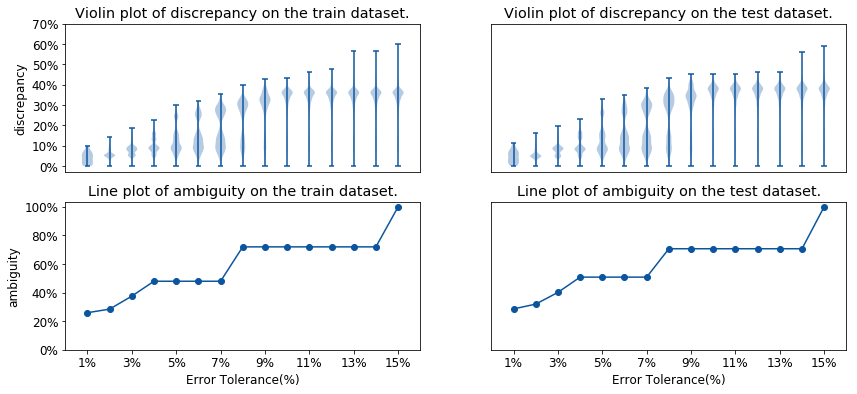

In [25]:
fig = plt.figure(figsize=(14, 6))

#sns.set_palette('coolwarm')
#sns.set_palette('gray')
sns.set_palette("Blues_r")

ax = fig.add_subplot(2, 2, 1)

ax.violinplot(discre_train_list[1:])
plt.title("Violin plot of discrepancy on the train dataset.")
#plt.xlabel("Error Tolerance(%)")
plt.ylabel("discrepancy")
ax.axes.xaxis.set_visible(False)
#plt.hlines(dp_test_eps_list[0], -1, 16, color="orange")
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15], 
#           ["1%", "3%", "5%", "7%", "9%", "11%", "13%", "15%"])
plt.xlim(0, 16)
ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]) 
ax.set_yticklabels( ["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%"])


ax = fig.add_subplot(2, 2, 2)
ax.violinplot(discre_test_list[1:])
plt.title("Violin plot of discrepancy on the test dataset.")
#plt.xlabel("Error Tolerance(%)")
#plt.ylabel("discrepancy")
#plt.hlines(dp_test_eps_list[0], -1, 16, color="orange")
#plt.xticks([1, 3, 5, 7, 9, 11, 13, 15], 
#           ["1%", "3%", "5%", "7%", "9%", "11%", "13%", "15%"])
ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]) 
plt.xlim(0, 16)
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)



ax = fig.add_subplot(2, 2, 3)
ax.plot(eps_list[1:], amb_train_list[1:], marker="o", label="Ambiguous Prediction")
plt.title("Line plot of ambiguity on the train dataset.")
plt.xlabel("Error Tolerance(%)")
plt.ylabel("ambiguity")
#plt.hlines(dp_test_eps_list[0], -1, 16, color="orange")
plt.xticks([1, 3, 5, 7, 9, 11, 13, 15], 
           ["1%", "3%", "5%", "7%", "9%", "11%", "13%", "15%"])
#ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]) 
#ax.set_yticklabels( ["0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%", "100%"])
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]) 
ax.set_yticklabels( ["0%", "20%", "40%", "60%", "80%", "100%"])
plt.xlim(0, 16)


ax = fig.add_subplot(2, 2, 4)
ax.plot(eps_list[1:], amb_test_list[1:], marker="o", label="Ambiguous Prediction")
plt.title("Line plot of ambiguity on the test dataset.")
plt.xlabel("Error Tolerance(%)")
plt.ylabel("ambiguity")
#plt.hlines(dp_test_eps_list[0], -1, 16, color="orange")
plt.xticks([1, 3, 5, 7, 9, 11, 13, 15], 
           ["1%", "3%", "5%", "7%", "9%", "11%", "13%", "15%"])
ax.axes.yaxis.set_visible(False)
plt.xlim(0, 16)
ax.set_yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]) 



plt.savefig("predictive_multiplicity_color.pdf", bbox_inches="tight", pad_inches=0.0)


plt.show()

In [26]:
def calc_discrepancy_all(X, model_list, model):
    d_list = []
    for i in range(len(model_list)):
        model_prime = model_list[i]
        d = 0
        for j in range(len(X)):
            if model.flow(X[j]) != model_prime.flow(X[j]): 
                #print(model.flow(X[j]))
                #print(model_prime.flow(X[j]))
                d += 1
            
        d_list.append(d)
    
    return max(d_list) / len(X)

def calc_ambiguity_all(X, model_list, model):
    ambiguity = 0
    best_pred = model.predict(X)
    for i in range(len(X)):
        for h in model_list:
            if model.flow(X[i]) != h.flow(X[i]):
                ambiguity += 1
                break
                
    return ambiguity / len(X)

In [27]:
eps = 1 / 100
rashomon = best_score + eps * err_num
model_list = [ row[0] for row in sort_corels if row[1] <= rashomon]
len(model_list)

31

In [28]:
discre_train_hist = []
discre_test_hist = []
for model in model_list:
    hist = calc_discrepancy_all(X_train, model_list, model)
    discre_train_hist.append(hist)
    hist2 = calc_discrepancy_all(X_test, model_list, model)
    discre_test_hist.append(hist2)
    
discre_train_hist

[0.09893666204345816,
 0.09785791339189398,
 0.09554630913854215,
 0.09600862998921252,
 0.14701803051317613,
 0.10309754969949145,
 0.10309754969949145,
 0.10309754969949145,
 0.10309754969949145,
 0.1437817845584836,
 0.10124826629680998,
 0.15040838341809215,
 0.10756665125597165,
 0.15210355987055016,
 0.11049468331021729,
 0.14316535675758976,
 0.15873015873015872,
 0.10171058714748035,
 0.10587147480351364,
 0.1423948220064725,
 0.11619664046848513,
 0.1598089073817229,
 0.10941593465865311,
 0.10926182770842965,
 0.14794267221451687,
 0.13083680073971335,
 0.1653567575897673,
 0.11373092926490985,
 0.1653567575897673,
 0.1591924795808291,
 0.1262135922330097]

In [29]:
amb_train_hist = []
amb_test_hist = []
for model in model_list:
    hist = calc_ambiguity_all(X_train, model_list, model)
    amb_train_hist.append(hist)
    hist2 = calc_ambiguity_all(X_test, model_list, model)
    amb_test_hist.append(hist2)
    

In [30]:
amb_train_hist

[0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833,
 0.25951610417629833]

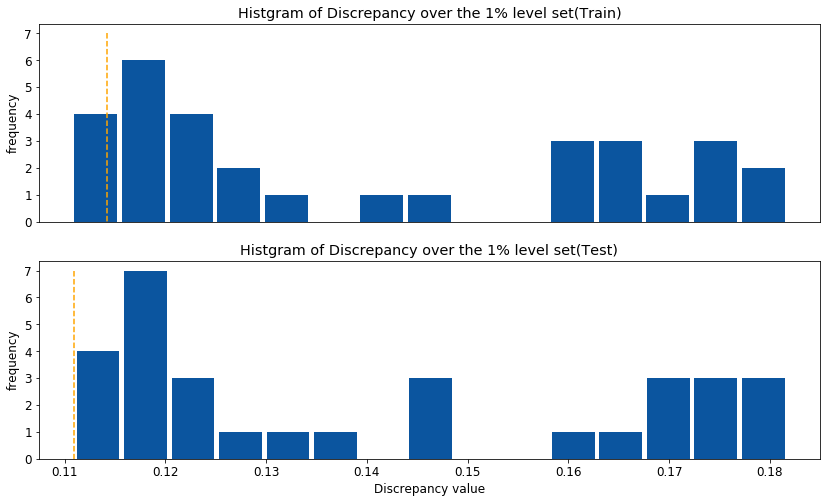

In [31]:
fig = plt.figure()

ax = fig.add_subplot(2, 1, 1)
plt.hist(discre_train_hist, bins=15, rwidth=0.9)
plt.title("Histgram of Discrepancy over the 1% level set(Train)")
plt.xlabel("Discrepancy value")
plt.ylabel("frequency")
ax.axes.xaxis.set_visible(False)
#ax.set_xlim(0.9, 0.2)
plt.vlines(discre_train_hist[0], 7, 0, "orange", linestyles='dashed')


ax = fig.add_subplot(2, 1, 2)
plt.hist(discre_test_hist, bins=15, rwidth=0.9)
plt.title("Histgram of Discrepancy over the 1% level set(Test)")
plt.xlabel("Discrepancy value")
plt.ylabel("frequency")
plt.vlines(discre_test_hist[0], 7, 0, "orange", linestyles='dashed')
#ax.set_xlim(0.9, 0.2)

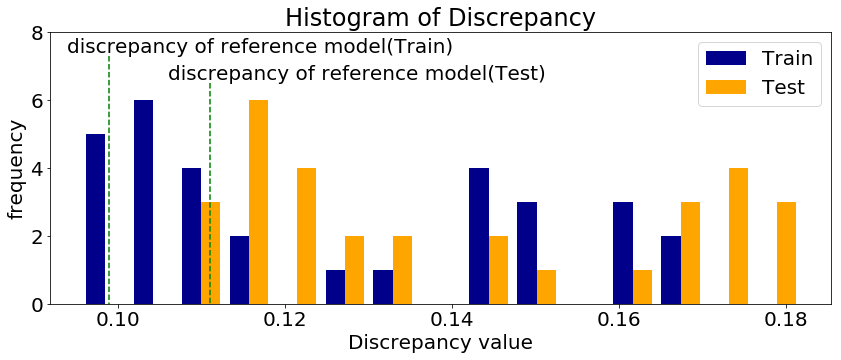

In [32]:
plt.rcParams["figure.figsize"] = (14, 5)
plt.rcParams["font.size"] = 20

label = ["Train", "Test"]
plt.hist([discre_train_hist, discre_test_hist], bins=15, 
         stacked=False, color=["darkblue", "orange"], label=label)
plt.title("Histogram of Discrepancy")
plt.xlabel("Discrepancy value")
plt.ylabel("frequency")
plt.legend()
plt.vlines(discre_train_hist[0], 7.3, 0, "green", linestyles='dashed')
plt.text(discre_train_hist[0]-0.005, 7.4, "discrepancy of reference model(Train)")
plt.vlines(discre_test_hist[0], 6.5, 0, "green", linestyles='dashed')
plt.text(discre_test_hist[0]-0.005, 6.6, "discrepancy of reference model(Test)")
plt.ylim(0, 8)

plt.savefig("discrepancy_histgram.pdf", bbox_inches="tight", pad_inches=0.0)